# Import Data and Train Model


In [1]:
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.dataset import random_split
from transformers import get_scheduler, AdamW
from datasets import load_metric
from torchsummary import summary
from kfold_functions import reset_weights
from sklearn.model_selection import KFold

import numpy as np
import librosa

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from tqdm.auto import tqdm
import random

seed_number = 69
torch.manual_seed(seed_number)
np.random.seed(seed_number)
random.seed(seed_number)

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data: Create Dataset


In [2]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            a = np.load(row["labels"])
            for i, v in enumerate(a):
                a[i] = int(v)
            y_loaded.append(a)

            x_loaded.append(np.load(row["data"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        cleaned_x = []
        cleaned_y = []
        for i, v in enumerate(continuous_y):
            if v != "2":
                cleaned_x.append(continuous_x[i])
                cleaned_y.append(v)

        continuous_x = np.array(cleaned_x)
        continuous_y = np.array(cleaned_y)
        return continuous_x, continuous_y

In [3]:
# %%capture
# Load the dataset
seizure_type = "general"
dataset = AbsenceDataset(
    f"processed_data/{seizure_type}/two_second_windows/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)
dataset.y = dataset.y.astype(int)

In [4]:
dataset.x.shape

(5349, 7, 500)

# Split Data

70%, 20%, 10%


In [5]:
dataset_len = len(dataset)
dataset_len

5349

In [6]:
train_set, eval_set, test_set = random_split(
    dataset,
    [0.7, 0.2, 0.1],
)

print(f"Train Split: {len(train_set)}")
print(f"Eval Split: {len(eval_set)}")
print(f"Test Split: {len(test_set)}")


print(f"Total: {len(train_set) + len(eval_set) + len(test_set)}")

Train Split: 3745
Eval Split: 1070
Test Split: 534
Total: 5349


In [7]:
# train_set.dataset.x[train_set.indices].shape, train_set.dataset.y[
#     train_set.indices
# ].shape

train_set_x = train_set.dataset.x[train_set.indices]
train_set_y = train_set.dataset.y[train_set.indices]

eval_set_x = eval_set.dataset.x[eval_set.indices]
eval_set_y = eval_set.dataset.y[eval_set.indices]

test_set_x = test_set.dataset.x[test_set.indices]
test_set_y = test_set.dataset.y[test_set.indices]

train_set_x.shape, train_set_y.shape, eval_set_x.shape, train_set_x.shape[
    0
] + eval_set_x.shape[0] + test_set_x.shape[0]

((3745, 7, 500), (3745,), (1070, 7, 500), 5349)

# Mel Spectrogram

Apply Mel Spectrogram to all test data and save as an image scaled 0-255.


Create Mel Spectrogram


In [16]:
n_fft = 200
window = "taylor"
hop_length = int(n_fft / 10)
fmin = 0
fmax = 30
n_mels = 40
sample_rate = 250
power = 3.0


# Train

stft_channel_data = []
for i, channels in enumerate(train_set_x):
    mels = librosa.feature.melspectrogram(
        y=channels,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        fmin=fmin,
        fmax=fmax,
        hop_length=hop_length,
        window=window,
        center=True,
        power=power,
    )
    # mels = np.log(mels + 1e-9)
    stft_channel_data.append((mels))
stft_channel_data = np.array(stft_channel_data)


# Val

val_stft_channel_data = []
for i, channels in enumerate(eval_set_x):
    mels = librosa.feature.melspectrogram(
        y=channels,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        fmin=fmin,
        fmax=fmax,
        hop_length=hop_length,
        window=window,
        center=True,
        power=power,
    )
    # mels = np.log(mels + 1e-9)
    val_stft_channel_data.append((mels))
val_stft_channel_data = np.array(val_stft_channel_data)

# Test

test_stft_channel_data = []
for i, channels in enumerate(test_set_x):
    mels = librosa.feature.melspectrogram(
        y=channels,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        fmin=fmin,
        fmax=fmax,
        hop_length=hop_length,
        window=window,
        center=True,
        power=power,
    )
    # mels = np.log(mels + 1e-9)
    test_stft_channel_data.append((mels))
test_stft_channel_data = np.array(test_stft_channel_data)

stft_channel_data.shape, val_stft_channel_data.shape, test_stft_channel_data.shape, stft_channel_data.shape[
    0
] + val_stft_channel_data.shape[
    0
] + test_stft_channel_data.shape[
    0
]

((3745, 7, 40, 26), (1070, 7, 40, 26), (534, 7, 40, 26), 5349)

In [17]:
# Train
train_db = []
for i, channels in enumerate(stft_channel_data):
    train_db.append(librosa.power_to_db((channels)))
train_db = np.array(train_db)

# Val
val_db = []
for i, channels in enumerate(val_stft_channel_data):
    val_db.append(librosa.power_to_db((channels)))
val_db = np.array(val_db)

# Test
test_db = []
for i, channels in enumerate(test_stft_channel_data):
    test_db.append(librosa.power_to_db((channels)))
test_db = np.array(test_db)


train_db.shape, val_db.shape, test_db.shape, train_db.shape[0] + val_db.shape[
    0
] + test_db.shape[0]

((3745, 7, 40, 26), (1070, 7, 40, 26), (534, 7, 40, 26), 5349)

In [18]:
# Train
train_db_mean = []
for i, channels in enumerate(train_db):
    train_db_mean.append(np.mean(channels, axis=0))
train_db_mean = np.array(train_db_mean)

# Val
val_db_mean = []
for i, channels in enumerate(val_db):
    val_db_mean.append(np.mean(channels, axis=0))
val_db_mean = np.array(val_db_mean)

# Test
test_db_mean = []
for i, channels in enumerate(test_db):
    test_db_mean.append(np.mean(channels, axis=0))
test_db_mean = np.array(test_db_mean)

train_db_mean.shape, val_db_mean.shape, test_db_mean.shape, train_db_mean.shape[
    0
] + val_db_mean.shape[0] + test_db_mean.shape[0]

((3745, 40, 26), (1070, 40, 26), (534, 40, 26), 5349)

In [19]:
bbbb = []
for i, v in enumerate(train_set_y):
    if v == 1:
        bbbb.append(i)
print(bbbb[:50])
print(bbbb[51:100])

[4, 7, 8, 11, 13, 17, 18, 26, 34, 46, 50, 65, 67, 71, 86, 91, 93, 94, 99, 108, 111, 116, 122, 124, 125, 128, 131, 146, 154, 158, 166, 167, 169, 170, 174, 175, 178, 180, 183, 189, 194, 201, 202, 210, 217, 219, 220, 222, 225, 231]
[239, 244, 245, 247, 250, 253, 261, 264, 268, 270, 273, 275, 278, 291, 293, 295, 298, 301, 303, 309, 310, 311, 314, 315, 319, 329, 332, 334, 337, 344, 355, 356, 360, 365, 366, 372, 387, 388, 393, 401, 402, 403, 409, 410, 412, 413, 415, 416, 418]


general
1


([], [])

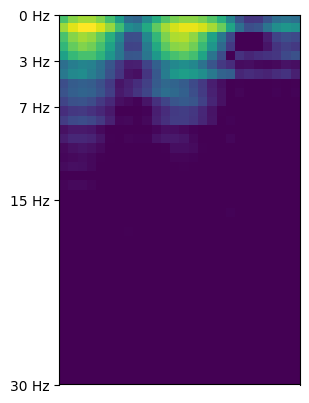

In [41]:
x = 239

print(seizure_type)
print(train_set_y[x])
plt.imshow(train_db_mean[x])
plt.yticks(
    [-0.5, (n_mels / 4) / 2 - 0.5, n_mels / 4 - 0.5, n_mels / 2 - 0.5, n_mels - 0.5],
    labels=[
        f"{fmin} Hz",
        f"{int(fmax/4/2)} Hz",
        f"{int(fmax/4)} Hz",
        f"{int(fmax/2)} Hz",
        f"{fmax} Hz",
    ],
)

plt.xticks([])

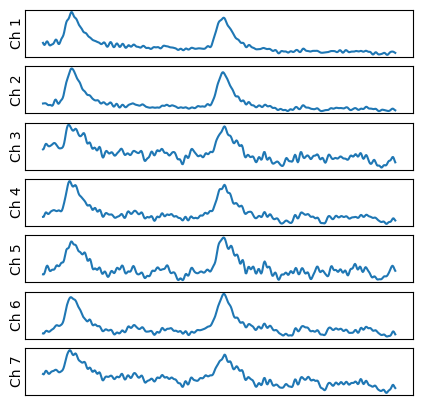

In [42]:
# plt.figure(figsize=(10, 5))
# plt.subplot(2, 1, 1)
# plt.plot(np.mean(train_db_mean[x], axis=1))
# plt.title("Mel Spectrogram Line Plot")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(2, 1, 2)
# for i in train_set_x[x]:
#     plt.plot(i)
# plt.title("Raw 7 Channels")
# plt.xticks([])
# plt.yticks([])

plt.figure(figsize=(5, 5))
for i, v in enumerate(train_set_x[x]):
    plt.subplot(7, 1, i + 1)
    plt.plot(v)
    # plt.title(f"Channel {i}", fontsize=10, pad=1)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f"Ch {i+1}", fontsize=10, labelpad=1)
plt.show()

Convert STFT to Image for Input


In [22]:
from skimage import io
from sklearn import preprocessing

In [23]:
# Output MFCC or Mel Spectrogram
to_image_train = train_db_mean
to_image_val = val_db_mean
to_image_test = test_db_mean

In [24]:
def sklearn_minnax(min, max, X):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [25]:
train_input_x = []
for i, melspec in enumerate(to_image_train):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    # img = np.repeat(img[..., np.newaxis], 3, -1)
    # img = np.transpose(img, (2, 0, 1))
    train_input_x.append(img.astype(np.uint8))
train_input_x = np.array(train_input_x)

val_input_x = []
for i, melspec in enumerate(to_image_val):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    # img = np.repeat(img[..., np.newaxis], 3, -1)
    # img = np.transpose(img, (2, 0, 1))
    val_input_x.append(img.astype(np.uint8))
val_input_x = np.array(val_input_x)

test_input_x = []
for i, melspec in enumerate(to_image_test):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    # img = np.repeat(img[..., np.newaxis], 3, -1)
    # img = np.transpose(img, (2, 0, 1))
    test_input_x.append(img.astype(np.uint8))
test_input_x = np.array(test_input_x)

# https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image

train_input_x.shape, val_input_x.shape, test_input_x.shape, train_input_x.shape[
    0
] + val_input_x.shape[0] + test_input_x.shape[0]

((3913, 40, 26), (1118, 40, 26), (559, 40, 26), 5590)

Smote on Mel Spectrogram


In [26]:
shape = train_input_x.shape
print(shape)

data_reshaped = train_input_x

data_reshaped = np.reshape(data_reshaped, (shape[0], shape[1] * shape[2]))

data_reshaped.shape

(3913, 40, 26)


(3913, 1040)

In [27]:
train_input_x, train_input_y = SMOTE(
    sampling_strategy="not majority", random_state=seed_number
).fit_resample(data_reshaped, train_set_y)

In [28]:
train_input_x = np.reshape(train_input_x, (train_input_x.shape[0], shape[1], shape[2]))
train_input_x.shape, train_input_y.shape

((7502, 40, 26), (7502,))

In [29]:
# train_input_x = train_input_x_fixed

Other Data


In [30]:
imb_input_x = []
for i, melspec in enumerate(to_image_train):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    # img = np.repeat(img[..., np.newaxis], 3, -1)
    # img = np.transpose(img, (2, 0, 1))
    imb_input_x.append(img.astype(np.uint8))
imb_input_x = np.array(imb_input_x)
imb_input_x.shape

(3913, 40, 26)

[1, 52, 55, 70, 82, 119, 135, 138, 167, 210, 251, 269, 271, 316, 333]
(40, 26)
[[161 136 127 ...  97 132 169]
 [120  95  86 ...  56  91 131]
 [250 255 249 ... 167 193 226]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


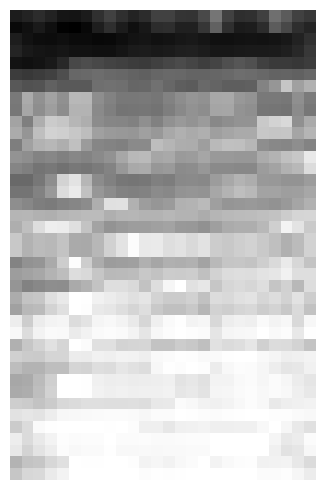

In [35]:
plt.figure(figsize=(5, 5))
plt.axis("off")

ones = []
for i, v in enumerate(train_input_y):
    if v == 1:
        ones.append(i)
print(ones[:15])

bb = 3
io.imshow(train_input_x[70])
print(train_input_x[bb].shape)

print(train_input_x[bb])

# io.imshow(train_input_x[1])
# print(train_set_y[x])
# print(train_set_x[x].shape)

# Remake Dataset


In [352]:
class Dataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [353]:
train_dataset = Dataset(
    (train_input_x, train_input_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
eval_dataset = Dataset(
    (val_input_x, eval_set.dataset.y[eval_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
test_dataset = Dataset(
    (test_input_x, test_set.dataset.y[test_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

In [354]:
imb_dataset = Dataset(
    (imb_input_x, train_set_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

# Save


In [355]:
main_folder_path = "melspectrograms/"
path = main_folder_path + seizure_type + "/"

In [356]:
np.save(f"{path}/train_{seizure_type}_x.npy", train_dataset.x)
np.save(f"{path}/train_{seizure_type}_y.npy", train_dataset.y)

np.save(f"{path}/validation_{seizure_type}_x.npy", eval_dataset.x)
np.save(f"{path}/validation_{seizure_type}_y.npy", eval_dataset.y)

np.save(f"{path}/test_{seizure_type}_x.npy", test_dataset.x)
np.save(f"{path}/test_{seizure_type}_y.npy", test_dataset.y)

In [357]:
np.save(f"{path}/imb_{seizure_type}_x.npy", imb_dataset.x)
np.save(f"{path}/imb_{seizure_type}_y.npy", imb_dataset.y)